In [1]:
import pandas as pd
import numpy as np
from nba_api.stats.static import players

import time 
import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import json
import cairosvg
import statsmodels.api as sm
import base64
import requests

from nba_api.stats.static import players,teams  

import plotly.express as px

from plotly.subplots import make_subplots


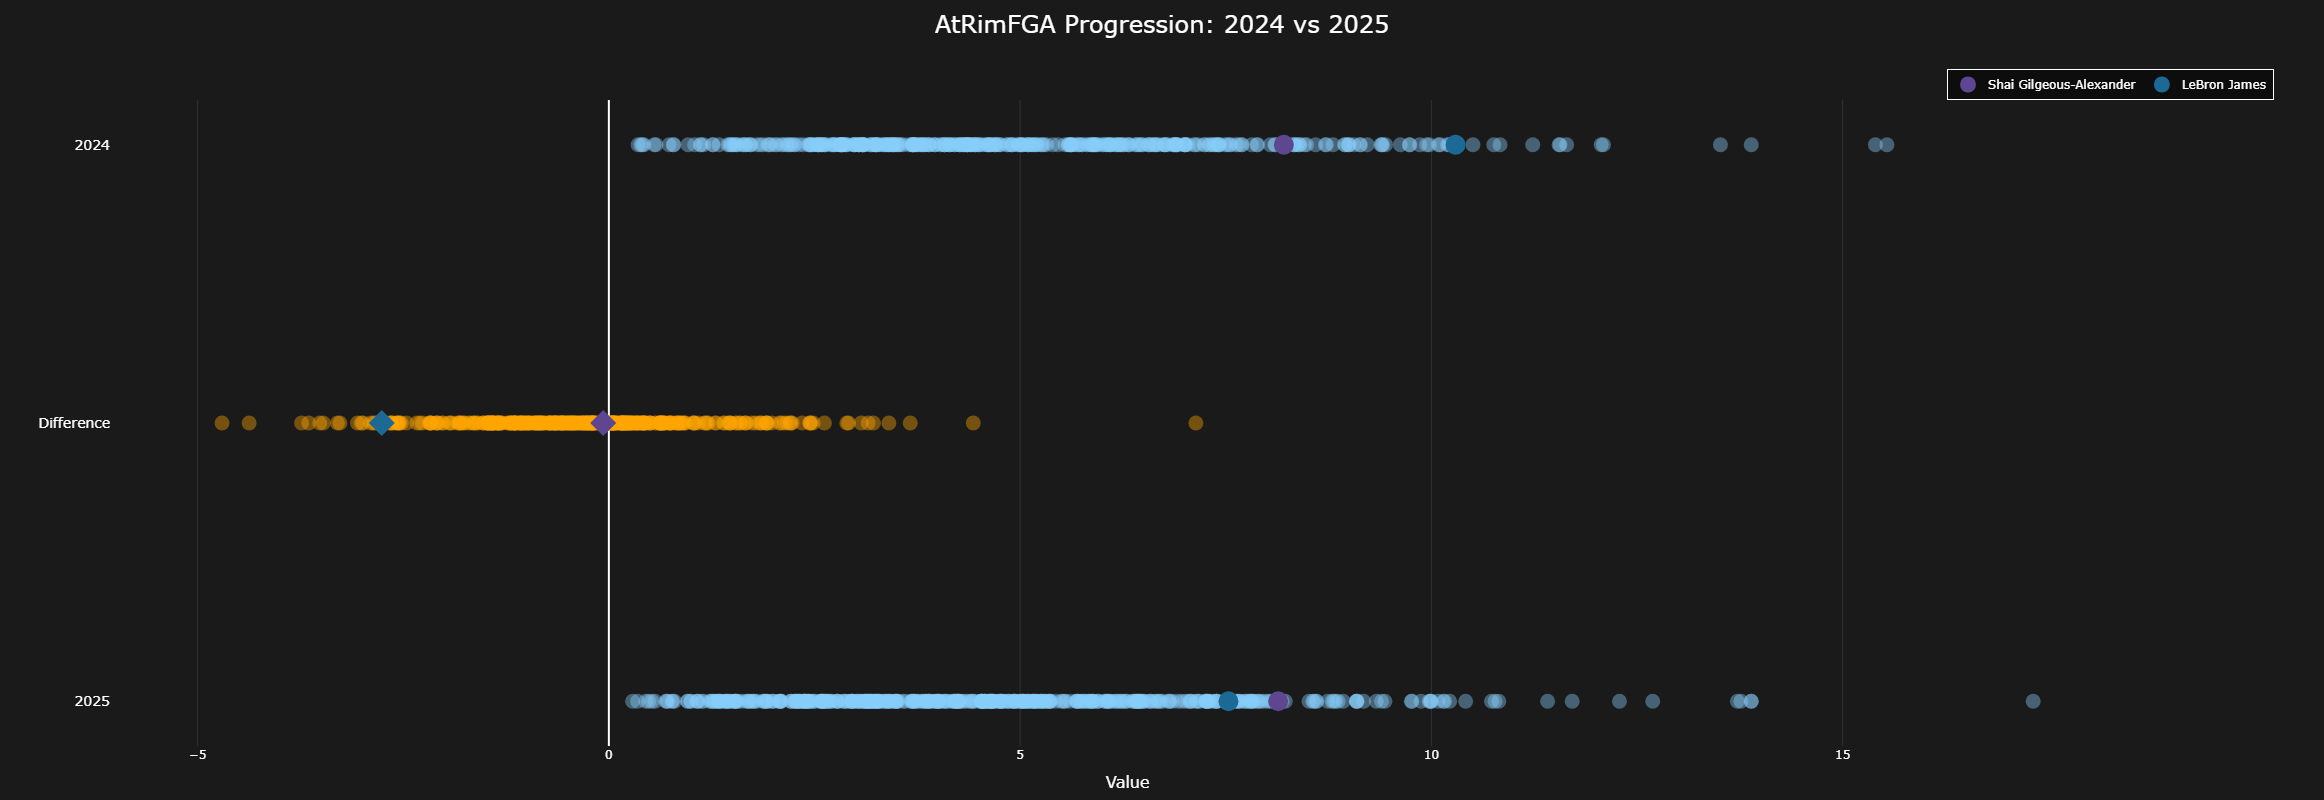

In [4]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import plotly.express as px

def player_progression(players,start_year,end_year, category,gp=10,mpg=12):

    

    oldframe=pd.read_csv(f'https://raw.githubusercontent.com/gabriel1200/player_sheets/refs/heads/master/year_totals/{start_year}.csv',usecols=['PLAYER_ID',category,'POSS','GP','MIN'])
    newframe=pd.read_csv(f'https://raw.githubusercontent.com/gabriel1200/player_sheets/refs/heads/master/year_totals/{end_year}.csv',usecols=['PLAYER_NAME','PLAYER_ID',category,'POSS','GP','MIN'])

    oldframe['MPG']=oldframe['MIN']/oldframe['GP']
    
    newframe['MPG']=newframe['MIN']/newframe['GP']

    oldframe=oldframe[oldframe.MPG>-mpg]
    newframe=newframe[newframe.MPG>-mpg]

    oldframe=oldframe[oldframe.GP>-gp]
    newframe=newframe[newframe.GP>-gp]
    perccheck=False
    for keyword in ['freq', 'accur', 'pct', '%']:
        if keyword in category.lower():
            newframe[category]=newframe[category]*100
            oldframe[category]=oldframe[category]*100

            perccheck = True
            
    if 'rating' not in category.lower() and not perccheck and 'rate' not in category.lower():
        newframe[category]=100*newframe[category]/newframe['POSS']
        oldframe[category]=100*oldframe[category]/oldframe['POSS']

    

    oldframe.rename(columns={category:str(start_year)+'_'+category,'POSS':f'{start_year}_POSS','GP':f'{start_year}_GP','MIN':f'{start_year}_MIN'},inplace=True)
    newframe.rename(columns={category:str(end_year)+'_'+category,'POSS':f'{end_year}_POSS','GP':f'{end_year}_GP','MIN':f'{end_year}_MIN'},inplace=True)


    

    comboframe=newframe.merge(oldframe,on='PLAYER_ID',how='left')
    comboframe[category+'_diff']=comboframe[str(end_year)+'_'+category] - comboframe[str(start_year)+'_'+category] 

    category_list=[str(end_year)+'_'+category ,str(start_year)+'_'+category,category+'_diff' ]

    

    scaler = MinMaxScaler()
    data = pd.DataFrame(
        scaler.fit_transform(comboframe[category_list]),
        columns=['norm_'+c for c in category_list],
        index=comboframe.index
    )
    old_cols=['PLAYER_ID','PLAYER_NAME',str(end_year)+'_'+category ,str(start_year)+'_'+category,category+'_diff' ]
    data[old_cols] = comboframe[old_cols]

    player_data=data[data.PLAYER_ID.isin(players)]




    
    color_palette = px.colors.qualitative.Plotly

    # Create the figure with two x-axes
    fig = make_subplots(rows=1, cols=1, specs=[[{"secondary_y": True}]])
    
    # Define custom colors
    grid_color = 'rgba(255, 255, 255, 0.1)'
    bg_color = '#1a1a1a'
    text_color = '#ffffff'
    color_palette = px.colors.qualitative.Prism
    
    # Plot the actual data points
    for i, cat in enumerate(category_list[:2]):  # Only plot start and end year
        # Plot all players data points
        fig.add_trace(go.Scatter(
            y=[cat] * len(data),
            x=data[cat],
            mode='markers',
            marker=dict(
                size=15,
                color='rgba(135, 206, 250, 0.4)',  # Light blue with transparency
                symbol='circle'
            ),
            hovertemplate="<b>%{text}</b><br><br>Value: %{x:.2f}<extra></extra>",
            text=data['PLAYER_NAME'],
            name='All Players',
            showlegend=False
        ), secondary_y=False)
        
        # Plot selected players with unique colors
        for j, player_id in enumerate(players):
            player_data = data[data.PLAYER_ID == player_id]
            fig.add_trace(go.Scatter(
                y=[cat],
                x=player_data[cat],
                mode='markers',
                marker=dict(
                    size=20,
                    color=color_palette[j % len(color_palette)],
                    symbol='circle'
                ),
                hovertemplate="<b>%{text}</b><br><br>Value: %{x:.2f}<extra></extra>",
                text=player_data['PLAYER_NAME'],
                name=player_data['PLAYER_NAME'].iloc[0],
                showlegend=(i==0)
            ), secondary_y=False)

    # Plot difference on secondary y-axis
    fig.add_trace(go.Scatter(
        y=[category+'_diff'] * len(data),
        x=data[category+'_diff'],
        mode='markers',
        marker=dict(
            size=15,
            color='rgba(255, 165, 0, 0.4)',  # Orange with transparency
            symbol='circle'
        ),
        hovertemplate="<b>%{text}</b><br><br>Difference: %{x:.2f}<extra></extra>",
        text=data['PLAYER_NAME'],
        name='All Players (Diff)',
        showlegend=False
    ), secondary_y=True)

    # Plot selected players' differences
    for j, player_id in enumerate(players):
        player_data = data[data.PLAYER_ID == player_id]
        fig.add_trace(go.Scatter(
            y=[category+'_diff'],
            x=player_data[category+'_diff'],
            mode='markers',
            marker=dict(
                size=20,
                color=color_palette[j % len(color_palette)],
                symbol='diamond'
            ),
            hovertemplate="<b>%{text}</b><br><br>Difference: %{x:.2f}<extra></extra>",
            text=player_data['PLAYER_NAME'],
            name=player_data['PLAYER_NAME'].iloc[0] + ' (Diff)',
            showlegend=False
        ), secondary_y=True)

    # Update layout
    fig.update_layout(
        title=dict(
            text=f'{category} Progression: {start_year} vs {end_year}',
            font=dict(size=24, color=text_color),
            x=0.5,
            y=0.98
        ),
        width=1200,
        height=800,
        showlegend=True,
        plot_bgcolor=bg_color,
        paper_bgcolor=bg_color,
       yaxis=dict(
            title=dict(text='', font=dict(size=16, color=text_color)),
            gridcolor=grid_color,
            showgrid=False,
            zeroline=True,
            zerolinecolor=grid_color,
            categoryarray=[f"{end_year}_"+category, category+'_diff', f"{start_year}_"+category],
            tickfont=dict(color=text_color, size=14),
            tickmode='array',
            tickvals=[f"{end_year}_"+category, category+'_diff', f"{start_year}_"+category],
            ticktext=[f"{end_year}", "Difference", f"{start_year}"],
            showticklabels=True
        ),
        xaxis=dict(
            title=dict(text='Value', font=dict(size=16, color=text_color)),
            gridcolor=grid_color,
            tickfont=dict(color=text_color, size=12),
            tickangle=0,
        ),

        hovermode='closest',
        legend=dict(
            font=dict(color=text_color, size=12),
            bgcolor='rgba(0,0,0,0.5)',
            bordercolor=text_color,
            borderwidth=1,
            orientation="h",
            yanchor="bottom",
            y=1.0,
            xanchor="right",
            x=1
        ),
        margin=dict(t=100, b=50, l=50, r=50)
    )

    # Update y-axes
    fig.update_yaxes(secondary_y=False, showgrid=False)
    fig.update_yaxes(secondary_y=True, showgrid=False, overlaying='y', side='right', visible=False)
    return fig
players=[1628983,2544]
fig=player_progression(players,2024,2025,'AtRimFGA')
fig.show()